# IT Job Classification

##IT Job Classification: 

Main Goal:
Build a classifier that can tell us from the job description and company description whether a job is IT or not, so that this column can be automatically populated for new job postings. After doing so, understand what important factors are which drives this classification. 

Sub Goal:
For the IT Job classification business question, you should aim to create supervised learning classification models that are able to classify based on the job text data accurately, is it an IT job. 

In [1]:
import gensim
import os
import collections
import smart_open
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

RANDOM_STATE = 4

In [6]:
#tagging IT jobs with a label

In [2]:
df = pd.read_csv('C:\\Users\\deeparam\\Desktop\\DMCA\\Sols_DSP_Capstone_Projects_PS_Chegg_2019\\6. TEXT MINING - ONLINE JOB POSTING\data job posts.csv')

df['text'] = df.jobpost.apply(gensim.utils.simple_preprocess)
df["label"] = df.IT
df = df[["text", "label"]]
df.head(5)

,text,label
0,"[ameria, investment, consulting, company, job,...",False
1,"[international, research, exchanges, board, ir...",False
2,"[caucasus, environmental, ngo, network, cenn, ...",False
3,"[manoff, group, job, title, bcc, specialist, p...",False
4,"[yerevan, brandy, company, job, title, softwar...",True


## Defining a Function to 'Read and Preprocess Text'

In [4]:
train, test = train_test_split(df, test_size=0.30, random_state=RANDOM_STATE, stratify=df["label"])

In [5]:
def read_corpus(dataframe, tokens_only=False):
    for i, row in enumerate(dataframe.iterrows()):
        if tokens_only:
            yield row[1]['text']
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(row[1]['text'], [row[1]['label']])

In [6]:
train_corpus = list(read_corpus(train))
test_corpus = list(read_corpus(test, tokens_only=True))

In [7]:
train_corpus[:3]

[TaggedDocument(words=[u'career', u'center', u'ngo', u'title', u'english', u'language', u'courses', u'open', u'to', u'eligibility', u'criteria', u'everyone', u'location', u'yerevan', u'armenia', u'detail', u'description', u'whether', u'you', u're', u'just', u'getting', u'started', u'already', u'know', u'english', u'and', u'want', u'to', u'improve', u'your', u'skills', u'want', u'to', u'prepare', u'for', u'an', u'exam', u'or', u'test', u'you', u'can', u'find', u'the', u'right', u'course', u'here', u'our', u'instructors', u'help', u'students', u'learn', u'english', u'with', u'most', u'innovative', u'methods', u'career', u'center', u'announces', u'below', u'mentioned', u'english', u'language', u'courses', u'general', u'english', u'course', u'consisting', u'total', u'of', u'levels', u'with', u'the', u'duration', u'of', u'months', u'each', u'beginner', u'elementary', u'pre', u'intermediate', u'intermediate', u'upper', u'intermediate', u'advanced', u'final', u'specialized', u'courses', u'con

In [8]:
len(test_corpus[:1][0])

504

## Training the Model

#Instantiate a Doc2Vec Object

In [9]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

#Building Vocabulary

In [10]:
model.build_vocab(train_corpus)

#Training model

In [11]:
np.show_config()

lapack_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/deeparam/AppData/Local/Continuum/anaconda2\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:\\Program Files (x86)\\Intel\\Composer XE 2013 SP1\\mkl', 'C:\\Program Files (x86)\\Intel\\Composer XE 2013 SP1\\mkl\\include', 'C:\\Program Files (x86)\\Intel\\Composer XE 2013 SP1\\mkl\\lib', 'C:/Users/deeparam/AppData/Local/Continuum/anaconda2\\Library\\include']
blas_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/deeparam/AppData/Local/Continuum/anaconda2\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:\\Program Files (x86)\\Intel\\Composer XE 2013 SP1\\mkl', 'C:\\Program Files (x86)\\Intel\\Composer XE 2013 SP1\\mkl\\include', 'C:\\Program Files (x86)\\Intel\\Composer XE 2013 SP1\\mkl\\lib', 'C:/Users/deeparam/AppData/Local/Continuum/anaconda2\\Library\\include']
lapack_mkl_info:
    lib

In [12]:
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

Wall time: 5min 14s


##Inferring a Vector a vector for any piece of text without having to re-train the model by passing a list of words to the model.infer_vector function. 

This vector can then be compared with other vectors via cosine similarity.

In [13]:
model.infer_vector(['only', 'you', 'can', 'prevent', 'forest', 'fires'])

array([-0.12897097, -0.26804233, -0.39207235, -0.1295527 ,  0.1742033 ,
        0.08659489,  0.09732154, -0.18926652,  0.01666071,  0.10198138,
       -0.13985059,  0.09280643, -0.39471805,  0.18737549, -0.14535816,
        0.01901447,  0.04802837,  0.27358568,  0.09447701, -0.6806455 ,
        0.01766047,  0.09829775,  0.5440664 ,  0.4739469 ,  0.41044265,
       -0.09056217,  0.20573795, -0.21327847,  0.3143653 ,  0.29843125,
       -0.11171989,  0.13253078,  0.16666424, -0.14281313, -0.13087334,
        0.79495144, -0.2131235 ,  0.12922905, -0.13735926,  0.05826812,
        0.6371311 , -0.3850845 , -0.15900627, -0.02022621,  0.29563686,
       -0.27366313, -0.1980835 , -0.18878055,  0.31496546,  0.12018483],
      dtype=float32)

## Assessing Model

We'll first infer new vectors for each document of the training corpus, comparing inferred vectors with the training corpus, and then returning the rank of the document based on self-similarity.Basically, we're pretending as if the training corpus is some new unseen data and then seeing how they compare with the trained model. 

In [14]:
doc_id = 0
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
inferred_vector = model.infer_vector(train_corpus[doc_id].words)
print("Inferred Vector: {}".format(inferred_vector))
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Document (0): «career center ngo title english language courses open to eligibility criteria everyone location yerevan armenia detail description whether you re just getting started already know english and want to improve your skills want to prepare for an exam or test you can find the right course here our instructors help students learn english with most innovative methods career center announces below mentioned english language courses general english course consisting total of levels with the duration of months each beginner elementary pre intermediate intermediate upper intermediate advanced final specialized courses consisting total of levels with the duration of months each business english pre intermediate business english intermediate business english upper intermediate final business english courses also cover special business writing and communication classes application procedures all interested candidates should visit career center office and register as member on mondays

## Testing the Model

We'll infer the vector for a randomly chosen test document, and compare the document to our model.

In [17]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(test_corpus) - 1)
inferred_vector = model.infer_vector(test_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Test Document (4926): «armentel cjsc title head of business segment marketing division open to eligibility criteria all interested candidates location yerevan armenia job description job plan kpi and conduct marketing analysis implement products development directions and tendencies mobile and fixed telephony services as well as internet market condition analysis and monitoring for business segment perform analysis and maintenance of actual market pricing offers perform analysis and promotion of value added services for business segment develop and support effective professional relationship with other subdivisions of the company as well as with external organizations and agencies work out strategies and assure preparation of promotion plans for data transfer and internet services convergent solutions and launching new products services special offers accomplish plans aims in accordance with commercial indicators develop and approve initiatives for business market kpi execution manage 

In [18]:
filename = "outputs/doc2vec_model"
model.save("outputs/doc2vec_model")

C:\Users\pankaj.s\AppData\Local\Continuum\anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [19]:
from gensim.models.doc2vec import Doc2Vec


model = Doc2Vec.load(filename)  # you can continue training with the loaded model!
model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## Using Doc2Vec with SVM

In [20]:
train_X, train_y = [], []
for corpora in train_corpus:
    train_X.append(model.infer_vector(corpora.words))
    train_y.append(corpora.tags[0])
    
train_X = np.array(train_X)
train_y = np.array(train_y)

In [21]:
test_X = []
for corpora in test_corpus:
    test_X.append(model.infer_vector(corpora))
    
test_X = np.array(test_X)

In [22]:
test_y = test['label']

In [23]:
from sklearn import svm

clf = svm.SVC(gamma=0.001, C=100.)

clf.fit(train_X, train_y)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [24]:
import pickle

filename = "outputs/doc2vec_svc.pkl"
pickle.dump(clf, open(filename, 'wb'))

In [25]:
import pickle

filename = "outputs/doc2vec_svc.pkl"
clf = pickle.load(open(filename, 'rb'))
predicted_y = clf.predict(test_X)

In [26]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report

def pretty_print_conf_matrix(y_true, y_pred, 
                             classes,
                             normalize=False,
                             title='Confusion matrix',
                             cmap=plt.cm.Blues):
 
    cm = confusion_matrix(y_true, y_pred)

    # Confusion Matrix Plot 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

    # Calculate normalized values 
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) #(axis=1)[:, np.newaxis]

    # Placing Numbers as Text on Confusion Matrix Plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

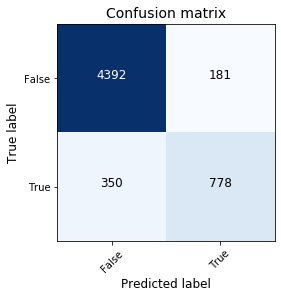

In [27]:
pretty_print_conf_matrix(y_true=test_y, y_pred=predicted_y, classes=["False", "True"])

In [28]:
rpt = classification_report(test_y, predicted_y)
print(rpt)

              precision    recall  f1-score   support

       False       0.93      0.96      0.94      4573
        True       0.81      0.69      0.75      1128

    accuracy                           0.91      5701
   macro avg       0.87      0.83      0.84      5701
weighted avg       0.90      0.91      0.90      5701



#In order to correctly classify whether a particular job posting is an IT job or not, we used two columns from the dataset, “jobpost” as the text corpus and “IT” as the label (IT job or not). 
 
We have reused the Pre-Processing methods in the Pre-processing section. As performed previously, we have generated the TF-IDF and reduced the dimension through Singular Value Decomposition 
 

##After which, Support Vector Machine (SVM) is used to perform classification on whether the job is an IT job or not. Initial Inspection showed that there is an imbalanced class as shown in the figure below. As such, we will change the increase the weightage for those job which are IT jobs. After splitting the available into 70% training and 30% testing, we train our SVM model and we predict on the test partition to obtain the results as shown in the confusion matrix.  
 
This model performed fairly well as F1 score were high on both classes.
#The model achieved >90% accuracy on test dataset. 

#These are the confusion matrix and others scores that were calculated based on the comparison between predicted versus actual target values (IT job or not) of test dataset